In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =1e-24

nband = 100

ng =6

ng_refs = (/ 6 /) 

nref =1

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 600 /) 

t_refs = (/ 250 /) 

tsfc =257

vstar = 620

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66/

data wgt
     &     /0.8 , 0.8 , 0.8 , 0.6,
     &     0.6 , 0.9/

atmosphere_profiles/saw75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

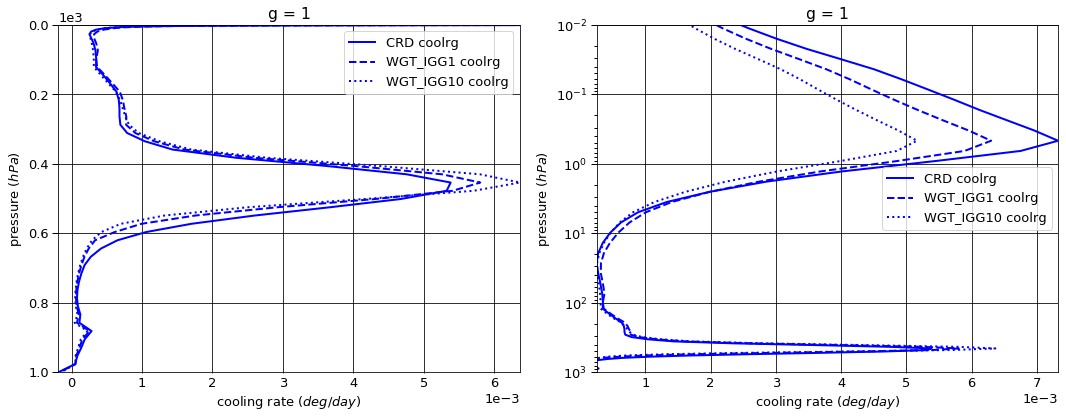

# Figure: cooling rate g-group 2

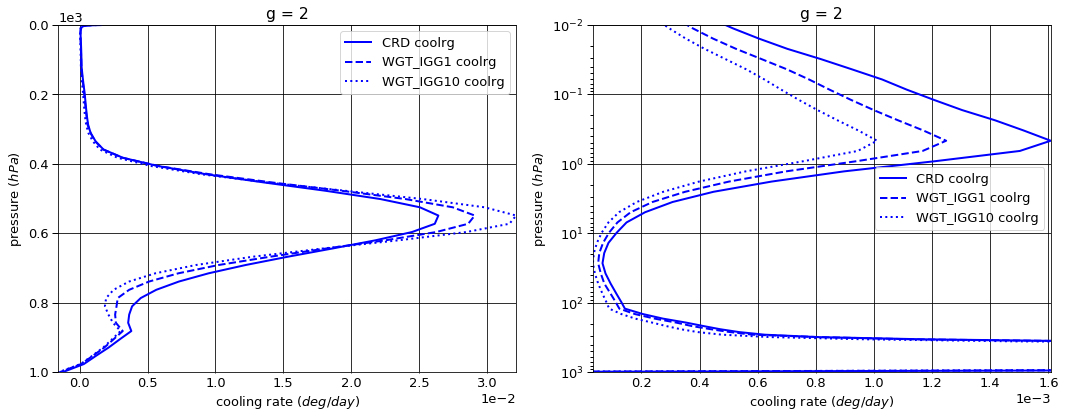

# Figure: cooling rate g-group 3

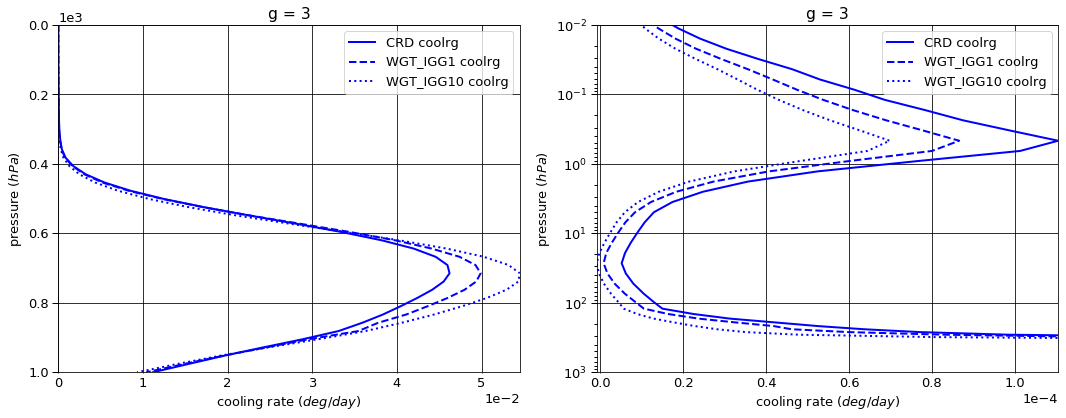

# Figure: cooling rate g-group 4

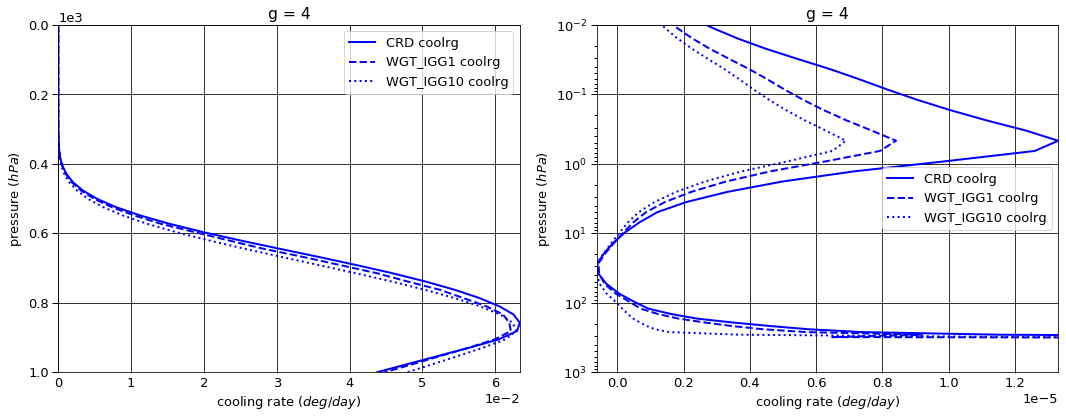

# Figure: cooling rate g-group 5

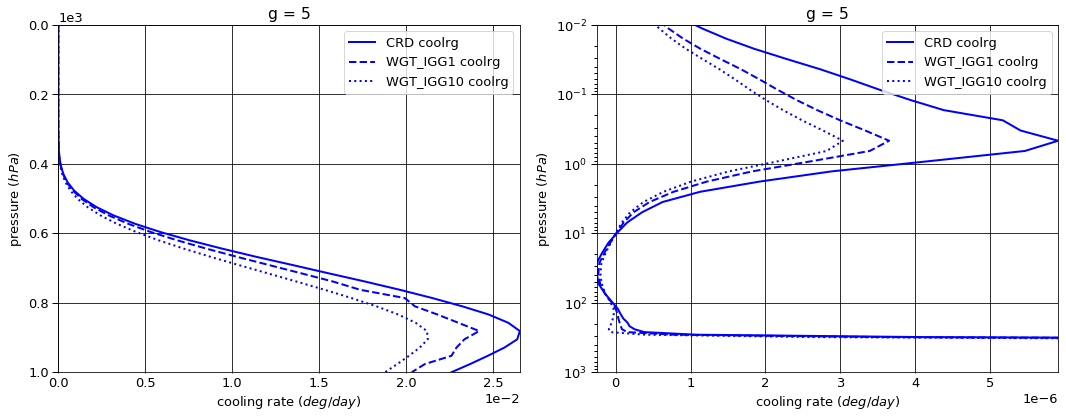

# Figure: cooling rate g-group 6

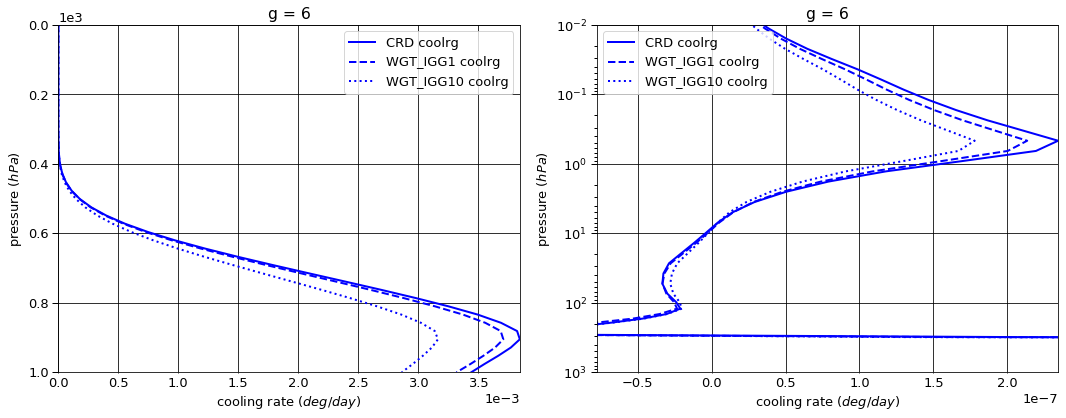

# Figure: cooling rate g-group total

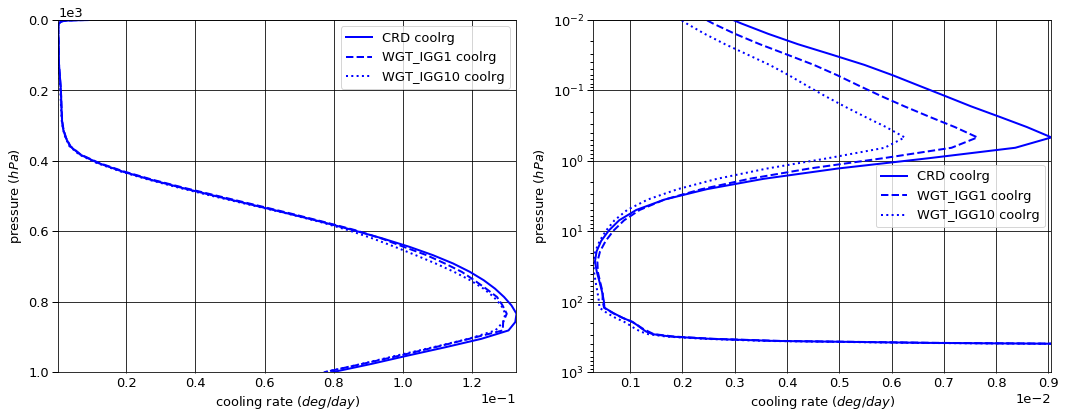

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.134341  0.000000  -0.134341
  1013.0   76     -0.208156  0.208959   0.000803
2 0.0      1      -0.825845  0.000000  -0.825845
  1013.0   76     -1.048624  1.058713   0.010089
3 0.0      1      -2.342669  0.000000  -2.342669
  1013.0   76     -2.526732  2.242641  -0.284091
4 0.0      1      -6.649780  0.000000  -6.649780
  1013.0   76     -6.742159  2.678162  -4.063997
5 0.0      1     -10.514918  0.000000 -10.514918
  1013.0   76    -10.539213  1.034317  -9.504896
6 0.0      1      -5.969318  0.000000  -5.969318
  1013.0   76     -5.972335  0.145359  -5.826976


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.130773  0.000000  -0.130773
  1013.0   76     -0.208156  0.208812   0.000655
2 0.0      1      -0.815937  0.000000  -0.815937
  1013.0   76     -1.048624  1.058898   0.010274
3 0.0      1      -2.338335  0.000000  -2.338335
  1013.0   76     -2.526732  2.344842  -0.181890
4 0.0      1      -6.656784  0.000000  -6.656784
  1013.0   76     -6.742159  2.598373  -4.143786
5 0.0      1     -10.516823  0.000000 -10.516823
  1013.0   76    -10.539213  0.929066  -9.610147
6 0.0      1      -5.969361  0.000000  -5.969361
  1013.0   76     -5.972335  0.140557  -5.831778


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.130197  0.000000  -0.130197
  1013.0   76     -0.208156  0.208712   0.000555
2 0.0      1      -0.814853  0.000000  -0.814853
  1013.0   76     -1.048624  1.058392   0.009768
3 0.0      1      -2.344603  0.000000  -2.344603
  1013.0   76     -2.526732  2.417647  -0.109084
4 0.0      1      -6.670548  0.000000  -6.670548
  1013.0   76     -6.742159  2.536061  -4.206098
5 0.0      1     -10.520876  0.000000 -10.520876
  1013.0   76    -10.539213  0.819982  -9.719231
6 0.0      1      -5.969876  0.000000  -5.969876
  1013.0   76     -5.972335  0.119255  -5.853080


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.003568  0.000000  0.003568
  1013.0   76     0.000000 -0.000148 -0.000148
2 0.0      1      0.009907  0.000000  0.009907
  1013.0   76     0.000000  0.000185  0.000185
3 0.0      1      0.004335  0.000000  0.004335
  1013.0   76     0.000000  0.102201  0.102201
4 0.0      1     -0.007004  0.000000 -0.007004
  1013.0   76     0.000000 -0.079789 -0.079789
5 0.0      1     -0.001905  0.000000 -0.001905
  1013.0   76     0.000000 -0.105250 -0.105250
6 0.0      1     -0.000042  0.000000 -0.000042
  1013.0   76     0.000000 -0.004802 -0.004802


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.004144  0.000000  0.004144
  1013.0   76     0.000000 -0.000248 -0.000248
2 0.0      1      0.010991  0.000000  0.010991
  1013.0   76     0.000000 -0.000321 -0.000321
3 0.0      1     -0.001933  0.000000 -0.001933
  1013.0   76     0.000000  0.175007  0.175007
4 0.0      1     -0.020768  0.000000 -0.020768
  1013.0   76     0.000000 -0.142101 -0.142101
5 0.0      1     -0.005958  0.000000 -0.005958
  1013.0   76     0.000000 -0.214335 -0.214335
6 0.0      1     -0.000557  0.000000 -0.000557
  1013.0   76     0.000000 -0.026104 -0.026104

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1      5.105533e-04
  1001.112500 75    -1.870030e-04
2 0.000312    1      8.748037e-05
  1001.112500 75    -1.278497e-03
3 0.000312    1      6.427063e-07
  1001.112500 75     1.117102e-02
4 0.000312    1     -4.857538e-07
  1001.112500 75     4.374318e-02
5 0.000312    1     -1.614856e-07
  1001.112500 75     2.259432e-02
6 0.000312    1     -8.982098e-09
  1001.112500 75     3.440468e-03


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      4.728005e-04
  1001.112500 75    -1.714307e-04
2 0.000312    1      4.904462e-05
  1001.112500 75    -1.497207e-03
3 0.000312    1     -7.207293e-08
  1001.112500 75     1.037741e-02
4 0.000312    1     -2.556536e-07
  1001.112500 75     4.478305e-02
5 0.000312    1     -1.108833e-07
  1001.112500 75     2.031562e-02
6 0.000312    1     -6.988744e-09
  1001.112500 75     3.317892e-03


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      3.610976e-04
  1001.112500 75    -1.488104e-04
2 0.000312    1      3.010602e-05
  1001.112500 75    -1.573513e-03
3 0.000312    1     -3.907933e-07
  1001.112500 75     9.307071e-03
4 0.000312    1     -2.568544e-07
  1001.112500 75     4.792191e-02
5 0.000312    1     -9.582505e-08
  1001.112500 75     1.877779e-02
6 0.000312    1     -5.811945e-09
  1001.112500 75     2.861950e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -3.775288e-05
  1001.112500 75     1.557232e-05
2 0.000312    1     -3.843575e-05
  1001.112500 75    -2.187098e-04
3 0.000312    1     -7.147792e-07
  1001.112500 75    -7.936150e-04
4 0.000312    1      2.301002e-07
  1001.112500 75     1.039860e-03
5 0.000312    1      5.060235e-08
  1001.112500 75    -2.278706e-03
6 0.000312    1      1.993353e-09
  1001.112500 75    -1.225766e-04


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.494557e-04
  1001.112500 75     3.819257e-05
2 0.000312    1     -5.737435e-05
  1001.112500 75    -2.950155e-04
3 0.000312    1     -1.033500e-06
  1001.112500 75    -1.863950e-03
4 0.000312    1      2.288994e-07
  1001.112500 75     4.178725e-03
5 0.000312    1      6.566057e-08
  1001.112500 75    -3.816527e-03
6 0.000312    1      3.170152e-09
  1001.112500 75    -5.785184e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-26.436871,0.000000,-26.436871
1013.0,76,-27.037219,7.368151,-19.669069



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-26.428013,0.000000,-26.428013
1013.0,76,-27.037219,7.280547,-19.756672



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-26.450953,0.000000,-26.450953
1013.0,76,-27.037219,7.160048,-19.877171



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.008859,0.000000,0.008859
1013.0,76,0.000000,-0.087603,-0.087603



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.014081,0.000000,-0.014081
1013.0,76,0.000000,-0.208102,-0.208102


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.000598
1001.112500,75,0.079483



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.000521
1001.112500,75,0.077125



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.000390
1001.112500,75,0.077146



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000077
1001.112500,75,-0.002358



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000208
1001.112500,75,-0.002337


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.00750,0.007722
2,0.03850,0.038815
3,0.09275,0.093538
4,0.24780,0.249559
5,0.38800,0.390004
6,0.22545,0.220362


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.620340e-21
2,2.553906e-22
3,4.025348e-23
4,6.344568e-24
5,1.000002e-24
6,1.307067e-25


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.620340e-21,NaN,0.00750,0.007722,0.00750,0.007722,600.0
2,2.553906e-22,0.157615,0.03850,0.038815,0.04600,0.046537,600.0
3,4.025348e-23,0.157615,0.09275,0.093538,0.13875,0.140075,600.0
4,6.344568e-24,0.157615,0.24780,0.249559,0.38655,0.389634,600.0
5,1.000002e-24,0.157615,0.38800,0.390004,0.77455,0.779638,600.0
6,1.307067e-25,0.130706,0.22545,0.220362,1.00000,1.000000,600.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     4.136226e-21  1.005154e-22  41.150151  2.835086e-07
      2 0.000312     1.767190e-22  3.603881e-24  49.035759  1.210106e-08
      3 0.000312     2.211090e-24  1.741677e-25  12.695180  1.536057e-10
      4 0.000312     2.932729e-25  2.377013e-26  12.337876  1.579499e-11
      5 0.000312     6.418275e-26  4.507425e-27  14.239339  3.433069e-12
      6 0.000312     4.032541e-27  4.223220e-28   9.548497  3.126708e-13
2     1 0.000750     4.276616e-21  1.011836e-22  42.265927  1.180506e-07
      2 0.000750     1.823742e-22  3.633224e-24  50.196250  5.029533e-09
      3 0.000750     2.341239e-24  1.766536e-25  13.253275  6.545883e-11
      4 0.000750     2.998684e-25  2.418287e-26  12.400035  6.503418e-12
      5 0.000750     6.652756e-26  4.589373e-27  14.496001  1.432178e-12
      6 0.000750     4.189750e-27  4.368812e-28   9.590135  1.308429e-13
3     1 0.001052     4.572858e-21  1.025207e-22  44.604258  1.769657e-07
      2 0.001052     1.943472e-22  3.693571e-24  52.617705  7.514689e-09
      3 0.001052     2.629484e-24  1.816513e-25  14.475447  1.029393e-10
      4 0.001052     3.140035e-25  2.502695e-26  12.546612  9.544515e-12
      5 0.001052     7.155334e-26  4.752369e-27  15.056352  2.156659e-12
      6 0.001052     4.525861e-27  4.672511e-28   9.686145  1.981898e-13
4     1 0.001476     4.890648e-21  1.039183e-22  47.062437  2.654395e-07
      2 0.001476     2.072570e-22  3.760264e-24  55.117674  1.124017e-08
      3 0.001476     2.960543e-24  1.869837e-25  15.833159  1.623579e-10
      4 0.001476     3.295473e-25  2.591641e-26  12.715780  1.404332e-11
      5 0.001476     7.707033e-26  4.918221e-27  15.670366  3.253425e-12
      6 0.001476     4.894192e-27  4.998698e-28   9.790934  3.006302e-13
5     1 0.002070     5.227135e-21  1.053642e-22  49.610148  3.978092e-07
      2 0.002070     2.210090e-22  3.833539e-24  57.651433  1.680805e-08
      3 0.002070     3.336194e-24  1.926152e-25  17.320509  2.562731e-10
      4 0.002070     3.464719e-25  2.684293e-26  12.907381  2.069324e-11
      5 0.002070     8.305949e-26  5.086713e-27  16.328717  4.909729e-12
      6 0.002070     5.293552e-27  5.344304e-28   9.905036  4.560080e-13
6     1 0.002904     5.583098e-21  1.068653e-22  52.244251  5.958721e-07
      2 0.002904     2.356581e-22  3.914423e-24  60.202516  2.513545e-08
      3 0.002904     3.762221e-24  1.985806e-25  18.945564  4.048948e-10
      4 0.002904     3.649373e-25  2.780893e-26  13.123023  3.054954e-11
      5 0.002904     8.956716e-26  5.260238e-27  17.027207  7.414709e-12
      6 0.002904     5.727255e-27  5.710584e-28  10.029193  6.919721e-13
7     1 0.004074     5.959331e-21  1.084326e-22  54.958853  8.919914e-07
      2 0.004074     2.512627e-22  4.004061e-24  62.751969  3.758780e-08
      3 0.004074     4.245085e-24  2.049387e-25  20.713928  6.401602e-10
      4 0.004074     3.851237e-25  2.881778e-26  13.364099  4.518510e-11
      5 0.004074     9.664494e-26  5.441458e-27  17.760854  1.120561e-11
      6 0.004074     6.199142e-27  6.099352e-28  10.163608  1.050505e-12
8     1 0.005714     6.356696e-21  1.100834e-22  57.744360  1.334315e-06
      2 0.005714     2.678872e-22  4.103814e-24  65.277616  5.620343e-08
      3 0.005714     4.792077e-24  2.117842e-25  22.627166  1.012620e-09
      4 0.005714     4.072373e-25  2.987468e-26  13.631522  6.695704e-11
      5 0.005714     1.043515e-25  5.633146e-27  18.524554  1.694594e-11
      6 0.005714     6.713773e-27  6.512808e-28  10.308568  1.595607e-12
9     1 0.008015     6.775950e-21  1.118432e-22  60.584376  1.994705e-06
      2 0.008015     2.855952e-22  4.215375e-24  67.750836  8.403700e-08
      3 0.008015     5.411170e-24  2.192541e-25  24.679901  1.602465e-09
      4 0.008015     4.315045e-25  3.098727e-26  13.925219  9.942054e-11
      5 0.008015     1.127502e-25  5.838157e-27  19.312637  2.564705e-11
      6 0.0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
